# Weak Supervision

In this notebook, we will discuss the concept of weak supervision in the context of anomaly detection. It will define what is often referred to as an *idealized anomaly detector* and compare it to a fully supervised classifier. The end of the notebook also has some macros for plotting the performance of multiple retrainings in terms of median and 68% confidence intervals.

The usual approach to find a powerful discriminant for distinguishing two classes of data (here signal and background) from each other, is to train a machine learning classifier (e.g. a neural network) to distinguish the classes from each other, based on some input features $x$. At each training iteration, we compare the output of the classifier $f(x)$ to the actual label $y$ (1 for signal, 0 for background) of the training data via the loss function (usually binary cross entropy) and optimize the weights of the classifier such that they match as well as possible. What the classifier learns then is to approximate the likelihood ratio $\frac{p_{sig}}{p_{bkg}}$, which is the most powerful test statistic according to the Neyman Pearson Lemma. This *fully supervised classifier* relies on knowing a-priori which training data are signal and which are background during training.

However, there might be cases where one does not have such truth labels in advance. A prominent case is anomaly detection where one searches for small hints of anomalous signal within an overwhelming background, in a model-agnostic way. Let's imagine the case that we only have our measured data, that consists of background and maybe some signal. In addition, we somehow got an extra sample of just background data. If that was the case, we could just train a classifier to distinguish these two classes (data=sig+bkg vs bkg). Our classifier would approach a likelihood ratio that is monotonically linked to the signal-vs-bkg one $\frac{p_{(sig+bkg)}}{p_{bkg}} = \frac{f_{sig} p_{sig} + (1- f_{sig}) p_{bkg}}{p_{bkg}} = f_{sig} \frac{p_{sig}}{p_{bkg}} + (1 - f_{sig})$ where $f_{sig}$ is the (unknown) signal fraction in the data.

The question is now where to get this magic background-only sample. One might have a very good Monte Carlo simulation, or one might instead generate it in-situ via some data-driven estimate. The latter is the approach that multiple weak supervision methods take, such as [CWoLa Hunting](https://arxiv.org/abs/1902.02634), [SALAD](https://arxiv.org/abs/2212.10579), [CATHODE](https://arxiv.org/abs/2109.00546), [CURTAINS](https://arxiv.org/abs/2203.09470), [FETA](https://arxiv.org/abs/2212.11285). For now, we just assume we already have such a large background-only sample and refer to this idealization as the *idealized anomaly detector* (IAD).

Here, we first illustrate the fully supervised training and will then compare it to the IAD.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys

from os.path import exists, join, dirname, realpath
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier

In [31]:
# :sunglasses:
plt.style.use('dark_background')

The input data are preprocessed via another script `demos/utils/data_preparation.py`. It downloads the [LHCO R\&D dataset](https://zenodo.org/records/4536377) and applies the preprocessing to extract the conditional feature $m=m_{jj}$ and four auxiliary features $x=(m_{j1}, \Delta m_{jj}, \tau_{21,j1}, \tau_{21,j2})$. Morevoer, it divides the $m$ spectrum into signal region and sidebands, and splits the data into training/validation/test sets. Furthermore, it consists of extra background-only samples, which we will make use of here, as well as an extra signal sample, which we will use in supervised training and for the common test set. By default, there are approximately 0.6% signal events in the "data".

For the purpose of this guide, we will only use the signal region, as the sideband is typically used to estimate the background-only sample in realistic weak supervision methods. Further, we will not use the "conditional feature" $m_{jj}$ for the training, even though this would be possible.

In [32]:
data_path = "./input_data/"

In [33]:
# data preparation (download and high-level preprocessing)
if not exists(join(data_path, "innerdata_test.npy")):
    process = subprocess.run(f"{sys.executable} {join(parent_dir, 'demos', 'utils', 'data_preparation.py')} --outdir {data_path}", shell=True, check=True)

In [34]:
# data loading
innerdata_train = np.load(join(data_path, "innerdata_train.npy"))
innerdata_val = np.load(join(data_path, "innerdata_val.npy"))
innerdata_test = np.load(join(data_path, "innerdata_test.npy"))
innerdata_extrabkg_train = np.load(join(data_path, "innerdata_extrabkg_train.npy"))
innerdata_extrabkg_val = np.load(join(data_path, "innerdata_extrabkg_val.npy"))
innerdata_extrabkg_test = np.load(join(data_path, "innerdata_extrabkg_test.npy"))
innerdata_extrasig = np.load(join(data_path, "innerdata_extrasig.npy"))

# splitting up the extra signal into train/val proportionally
# also leaving some for the test set
innerdata_extrasig_test = innerdata_extrasig[:20000]
innerdata_extrasig_train, innerdata_extrasig_val = train_test_split(innerdata_extrasig[20000:],
                                                                    train_size=len(innerdata_train)/(len(innerdata_train)+len(innerdata_val)),
                                                                    random_state=42)

The supervised classifier would realistically be trained on a good simulation of the two classes, where the labels are available. We assume this can be done with plenty of simulated signal, more than we would expect to see in the real data. Thus, we throw all our training data, as well as the extra signal and background into the supervised classifier training set.

In [35]:
sup_clsf_train_set = np.vstack([innerdata_train,
                            innerdata_extrabkg_train,
                            innerdata_extrasig_train])
sup_clsf_val_set = np.vstack([innerdata_val,
                          innerdata_extrabkg_val,
                          innerdata_extrasig_val])

sup_clsf_train_set = shuffle(sup_clsf_train_set, random_state=42)
sup_clsf_val_set = shuffle(sup_clsf_val_set, random_state=42)

In [36]:
# either train new NN classifier to distinguish between signal and background

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

X_train = sup_scaler.transform(sup_clsf_train_set[:, 1:-1])
y_train = sup_clsf_train_set[:, -1]
X_val = sup_scaler.transform(sup_clsf_val_set[:, 1:-1])
y_val = sup_clsf_val_set[:, -1]

sup_classifier_savedir = "./trained_classifiers_supervised_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(sup_classifier_savedir, "CLSF_models")):
    sup_classifier_model = NeuralNetworkClassifier(save_path=sup_classifier_savedir,
                                                   n_inputs=X_train.shape[1],
                                                   early_stopping=True, epochs=None,
                                                   verbose=True)
    sup_classifier_model.fit(X_train, y_train, X_val, y_val)
else:
    print(f"The model exists already in {sup_classifier_savedir}. Remove first if you want to overwrite.")

The model exists already in ./trained_classifiers_supervised_0/. Remove first if you want to overwrite.


In [37]:
# or alternatively load existing classifer model

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

sup_classifier_savedir = "./trained_classifiers_supervised_0/"
sup_classifier_model = NeuralNetworkClassifier(save_path=sup_classifier_savedir,
                                               n_inputs=sup_clsf_train_set[:, 1:-1].shape[1],
                                               load=True)

/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

We can now evaluate the performance of our supervised classifier in terms of ROC curves. Another useful metric in anomaly detection is the significance improvement characteristic: how much significance ($\frac{S}{\sqrt(B)}$) we would achieve after applying a cut on our classifier output, divided by the significance without any selection. The efficiency in the x-axis quantifies how tight we apply a cut.

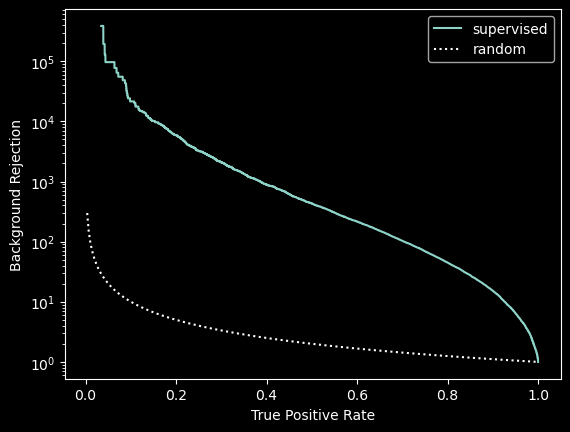

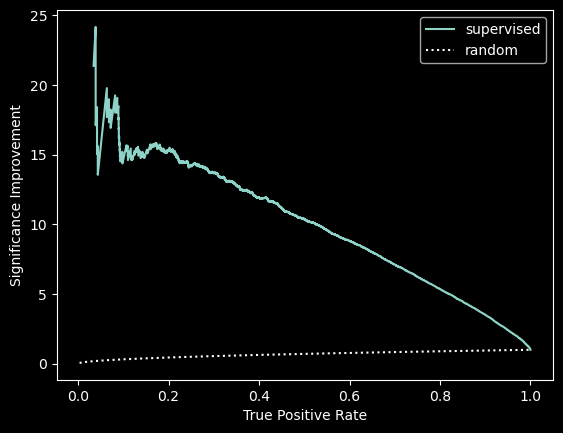

In [38]:
# now let's evaluate the signal extraction performance

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

X_test = sup_scaler.transform(clsf_test_set[:, 1:-1])
y_test = clsf_test_set[:, -1]

preds_test = sup_classifier_model.predict(X_test)

with np.errstate(divide='ignore', invalid='ignore'):
    fpr, tpr, _ = roc_curve(y_test, preds_test)
    bkg_rej = 1 / fpr
    sic = tpr / np.sqrt(fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# ROC curve
plt.plot(tpr, bkg_rej, label="supervised")
plt.plot(random_tpr, random_bkg_rej, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

# SIC curve
plt.plot(tpr, sic, label="supervised")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

This classifier clearly yields good separation between signal and background data.

Now we would like to move on to training an idealized anomaly detector. We just take the "data" with mostly background and a small fraction of signal, and train a classifier to distinguish it from a pure background sample.

In [39]:
# assigning label 1 to "data"
iad_clsf_train_data = innerdata_train.copy()
iad_clsf_train_data[:, -1] = np.ones_like(iad_clsf_train_data[:, -1])
iad_clsf_val_data = innerdata_val.copy()
iad_clsf_val_data[:, -1] = np.ones_like(iad_clsf_val_data[:, -1])

# and label 0 to background
iad_clsf_train_bkg = innerdata_extrabkg_train.copy()
iad_clsf_train_bkg[:, -1] = np.zeros_like(iad_clsf_train_bkg[:, -1])
iad_clsf_val_bkg = innerdata_extrabkg_val.copy()
iad_clsf_val_bkg[:, -1] = np.zeros_like(iad_clsf_val_bkg[:, -1])

# mixing together and shuffling
iad_clsf_train_set = np.vstack([iad_clsf_train_data, iad_clsf_train_bkg])
iad_clsf_val_set = np.vstack([iad_clsf_val_data, iad_clsf_val_bkg])
iad_clsf_train_set = shuffle(iad_clsf_train_set, random_state=42)
iad_clsf_val_set = shuffle(iad_clsf_val_set, random_state=42)

In [40]:
# either train new NN classifier to distinguish between "data" and background

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

X_train = iad_scaler.transform(iad_clsf_train_set[:, 1:-1])
y_train = iad_clsf_train_set[:, -1]
X_val = iad_scaler.transform(iad_clsf_val_set[:, 1:-1])
y_val = iad_clsf_val_set[:, -1]

iad_classifier_savedir = "./trained_classifiers_idealized-ad_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(iad_classifier_savedir, "CLSF_models")):
    iad_classifier_model = NeuralNetworkClassifier(save_path=iad_classifier_savedir,
                                                   n_inputs=X_train.shape[1],
                                                   early_stopping=True, epochs=None,
                                                   verbose=True)
    iad_classifier_model.fit(X_train, y_train, X_val, y_val)
else:
    print(f"The model exists already in {iad_classifier_savedir}. Remove first if you want to overwrite.")

The model exists already in ./trained_classifiers_idealized-ad_0/. Remove first if you want to overwrite.


In [41]:
# or alternatively load existing classifer model

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

iad_classifier_savedir = "./trained_classifiers_idealized-ad_0/"
iad_classifier_model = NeuralNetworkClassifier(save_path=iad_classifier_savedir,
                                               n_inputs=iad_clsf_train_set[:, 1:-1].shape[1],
                                               load=True)

/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

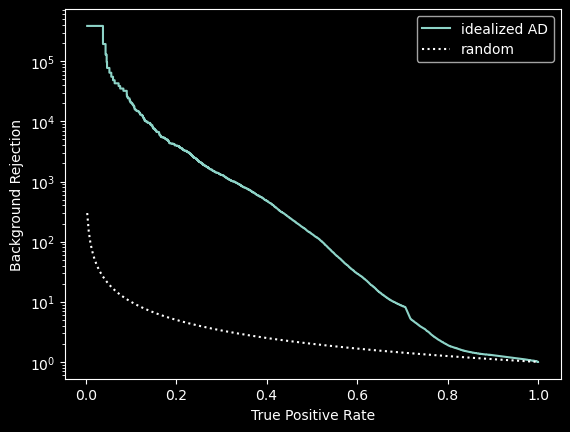

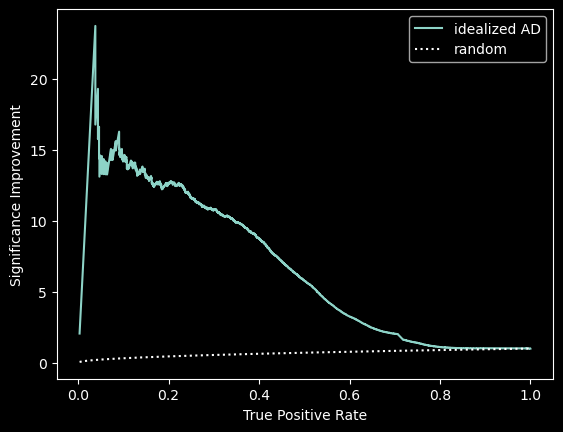

In [42]:
# now let's evaluate the signal extraction performance on the same test set

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

X_test = iad_scaler.transform(clsf_test_set[:, 1:-1])
y_test = clsf_test_set[:, -1]

preds_test = iad_classifier_model.predict(X_test)

with np.errstate(divide='ignore', invalid='ignore'):
    fpr, tpr, _ = roc_curve(y_test, preds_test)
    bkg_rej = 1 / fpr
    sic = tpr / np.sqrt(fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# ROC curve
plt.plot(tpr, bkg_rej, label="idealized AD")
plt.plot(random_tpr, random_bkg_rej, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

# SIC curve
plt.plot(tpr, sic, label="idealized AD")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

The plots above should also show quite good significance improvement, however a bit lower than in the fully supervised case. Under perfect training conditions, the two should be equal, but in practice we would need more and more training data with decreasing signal fractions to achieve this.

For the fun of it, let's compare the two approaches more thoroughly in terms of their signal extraction performance, rather than looking at two individual trainings. We will train ten classifiers each with the same data, then show their performance in terms of median and 68% confidence interval bands.

In [43]:
# either train new NN classifiers to distinguish between signal and background

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

X_train = sup_scaler.transform(sup_clsf_train_set[:, 1:-1])
y_train = sup_clsf_train_set[:, -1]
X_val = sup_scaler.transform(sup_clsf_val_set[:, 1:-1])
y_val = sup_clsf_val_set[:, -1]

sup_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_supervised_{i}/"     
    sup_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=X_train.shape[1],
                                                  early_stopping=True, epochs=None,
                                                  verbose=True))

    # We don't want to overwrite the model if it already exists.
    if not exists(join(_classifier_savedir, "CLSF_models")):
        sup_model_list[-1].fit(X_train, y_train, X_val, y_val)
    else:
        print(f"The model exists already in {_classifier_savedir}. Remove first if you want to overwrite. Loading its best state now.")
        sup_model_list[-1].load_best_model()

/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

The model exists already in ./trained_classifiers_supervised_0/. Remove first if you want to overwrite. Loading its best state now.
The model exists already in ./trained_classifiers_supervised_1/. Remove first if you want to overwrite. Loading its best state now.
The model exists already in ./trained_classifiers_supervised_2/. Remove first if you want to overwrite. Loading its best state now.
The model exists already in ./trained_classifiers_supervised_3/. Remove first if you want to overwrite. Loading its best state now.
The model exists already in ./trained_classifiers_supervised_4/. Remove first if you want to overwrite. Loading its best state now.
The model exists already in ./trained_classifiers_supervised_5/. Remove first if you want to overwrite. Loading its best state now.
The model exists already in ./trained_classifiers_supervised_6/. Remove first if you want to overwrite. Loading its best state now.
The model exists already in ./trained_classifiers_supervised_7/. Remove firs

Train loss: 0.247391: 100%|██████████| 302370/302370 [00:08<00:00, 35806.13it/s]


Validation loss: 0.22299507438756858

Epoch: 1


Train loss: 0.223731: 100%|██████████| 302370/302370 [00:08<00:00, 36609.84it/s]


Validation loss: 0.21976283245785222

Epoch: 2


Train loss: 0.221045: 100%|██████████| 302370/302370 [00:08<00:00, 36367.10it/s]


Validation loss: 0.21796450693706038

Epoch: 3


Train loss: 0.219888: 100%|██████████| 302370/302370 [00:08<00:00, 36421.75it/s]


Validation loss: 0.21954287338029047

Epoch: 4


Train loss: 0.219132: 100%|██████████| 302370/302370 [00:08<00:00, 35658.89it/s]


Validation loss: 0.22176746616887438

Epoch: 5


Train loss: 0.218503: 100%|██████████| 302370/302370 [00:08<00:00, 35397.64it/s]


Validation loss: 0.21673814587911983

Epoch: 6


Train loss: 0.217647: 100%|██████████| 302370/302370 [00:08<00:00, 35832.37it/s]


Validation loss: 0.2164330266463529

Epoch: 7


Train loss: 0.217073: 100%|██████████| 302370/302370 [00:08<00:00, 34859.57it/s]


Validation loss: 0.21775711418906596

Epoch: 8


Train loss: 0.216841: 100%|██████████| 302370/302370 [00:09<00:00, 30753.84it/s]


Validation loss: 0.2154211470465751

Epoch: 9


Train loss: 0.216737: 100%|██████████| 302370/302370 [00:10<00:00, 28635.41it/s]


Validation loss: 0.215452202186463

Epoch: 10


Train loss: 0.216346: 100%|██████████| 302370/302370 [00:08<00:00, 34179.31it/s]


Validation loss: 0.21489813367652286

Epoch: 11


Train loss: 0.215962: 100%|██████████| 302370/302370 [00:08<00:00, 34479.37it/s]


Validation loss: 0.21468878016350376

Epoch: 12


Train loss: 0.216099: 100%|██████████| 302370/302370 [00:08<00:00, 34707.99it/s]


Validation loss: 0.21510312063678813

Epoch: 13


Train loss: 0.215795: 100%|██████████| 302370/302370 [00:08<00:00, 35199.07it/s]


Validation loss: 0.21677777886770333

Epoch: 14


Train loss: 0.215297: 100%|██████████| 302370/302370 [00:08<00:00, 35762.82it/s]


Validation loss: 0.21742223226910184

Epoch: 15


Train loss: 0.215089: 100%|██████████| 302370/302370 [00:08<00:00, 34788.57it/s]


Validation loss: 0.21733649293328547

Epoch: 16


Train loss: 0.214917: 100%|██████████| 302370/302370 [00:08<00:00, 35243.41it/s]


Validation loss: 0.2165581360933887

Epoch: 17


Train loss: 0.214710: 100%|██████████| 302370/302370 [00:08<00:00, 35206.05it/s]


Validation loss: 0.2136445036549477

Epoch: 18


Train loss: 0.214453: 100%|██████████| 302370/302370 [00:08<00:00, 34781.59it/s]


Validation loss: 0.21454811391367273

Epoch: 19


Train loss: 0.213814: 100%|██████████| 302370/302370 [00:08<00:00, 35150.04it/s]


Validation loss: 0.21633428311461855

Epoch: 20


Train loss: 0.213563: 100%|██████████| 302370/302370 [00:08<00:00, 35143.92it/s]


Validation loss: 0.21563337106423772

Epoch: 21


Train loss: 0.213239: 100%|██████████| 302370/302370 [00:08<00:00, 35781.54it/s]


Validation loss: 0.21397767250135447

Epoch: 22


Train loss: 0.213122: 100%|██████████| 302370/302370 [00:08<00:00, 34805.19it/s]


Validation loss: 0.21415535216308704

Epoch: 23


Train loss: 0.213154: 100%|██████████| 302370/302370 [00:08<00:00, 35731.60it/s]


Validation loss: 0.21364770836321412

Epoch: 24


Train loss: 0.212913: 100%|██████████| 302370/302370 [00:08<00:00, 35553.27it/s]


Validation loss: 0.21293023352979853

Epoch: 25


Train loss: 0.212796: 100%|██████████| 302370/302370 [00:08<00:00, 35449.89it/s]


Validation loss: 0.21508754212765177

Epoch: 26


Train loss: 0.212489: 100%|██████████| 302370/302370 [00:08<00:00, 35438.37it/s]


Validation loss: 0.21354811369993124

Epoch: 27


Train loss: 0.212381: 100%|██████████| 302370/302370 [00:08<00:00, 35001.36it/s]


Validation loss: 0.21363289817503303

Epoch: 28


Train loss: 0.211833: 100%|██████████| 302370/302370 [00:08<00:00, 35748.38it/s]


Validation loss: 0.21533567560895991

Epoch: 29


Train loss: 0.211984: 100%|██████████| 302370/302370 [00:08<00:00, 35575.15it/s]


Validation loss: 0.21253573074462306

Epoch: 30


Train loss: 0.212199: 100%|██████████| 302370/302370 [00:08<00:00, 34698.72it/s]


Validation loss: 0.2193098934402891

Epoch: 31


Train loss: 0.211953: 100%|██████████| 302370/302370 [00:08<00:00, 35576.05it/s]


Validation loss: 0.2165806412412103

Epoch: 32


Train loss: 0.212059: 100%|██████████| 302370/302370 [00:08<00:00, 35488.45it/s]


Validation loss: 0.2126949654168384

Epoch: 33


Train loss: 0.211824: 100%|██████████| 302370/302370 [00:09<00:00, 32493.16it/s]


Validation loss: 0.21496378970184143

Epoch: 34


Train loss: 0.211628: 100%|██████████| 302370/302370 [00:10<00:00, 29399.26it/s]


Validation loss: 0.21310127993013447

Epoch: 35


Train loss: 0.211736: 100%|██████████| 302370/302370 [00:10<00:00, 28761.54it/s]


Validation loss: 0.2129095878760526

Epoch: 36


Train loss: 0.211445: 100%|██████████| 302370/302370 [00:10<00:00, 28884.17it/s]


Validation loss: 0.21467943378504675

Epoch: 37


Train loss: 0.211383: 100%|██████████| 302370/302370 [00:10<00:00, 29352.91it/s]


Validation loss: 0.2127482490459825

Epoch: 38


Train loss: 0.211301: 100%|██████████| 302370/302370 [00:08<00:00, 35456.98it/s]


Validation loss: 0.21271407614657833

Epoch: 39


Train loss: 0.211496: 100%|██████████| 302370/302370 [00:08<00:00, 34864.46it/s]
/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

Validation loss: 0.21420188861288084
Early stopping at epoch 39
Loading best model state...

Epoch: 0


Train loss: 0.247935: 100%|██████████| 302370/302370 [00:08<00:00, 34990.57it/s]


Validation loss: 0.23698547395171632

Epoch: 1


Train loss: 0.224219: 100%|██████████| 302370/302370 [00:08<00:00, 35055.96it/s]


Validation loss: 0.2246066508494365

Epoch: 2


Train loss: 0.221425: 100%|██████████| 302370/302370 [00:08<00:00, 36389.79it/s]


Validation loss: 0.22074015285748586

Epoch: 3


Train loss: 0.220319: 100%|██████████| 302370/302370 [00:08<00:00, 35429.60it/s]


Validation loss: 0.22207624285843722

Epoch: 4


Train loss: 0.219281: 100%|██████████| 302370/302370 [00:08<00:00, 35249.09it/s]


Validation loss: 0.2157793418427182

Epoch: 5


Train loss: 0.218318: 100%|██████████| 302370/302370 [00:08<00:00, 35685.29it/s]


Validation loss: 0.21638258404223024

Epoch: 6


Train loss: 0.218109: 100%|██████████| 302370/302370 [00:08<00:00, 35669.79it/s]


Validation loss: 0.21597263445709922

Epoch: 7


Train loss: 0.217332: 100%|██████████| 302370/302370 [00:08<00:00, 36277.38it/s]


Validation loss: 0.2162281770804885

Epoch: 8


Train loss: 0.216915: 100%|██████████| 302370/302370 [00:08<00:00, 34395.86it/s]


Validation loss: 0.21617188615973587

Epoch: 9


Train loss: 0.216914: 100%|██████████| 302370/302370 [00:08<00:00, 34425.91it/s]


Validation loss: 0.2156197530164081

Epoch: 10


Train loss: 0.216480: 100%|██████████| 302370/302370 [00:08<00:00, 35530.90it/s]


Validation loss: 0.21703870039267145

Epoch: 11


Train loss: 0.216256: 100%|██████████| 302370/302370 [00:10<00:00, 28846.61it/s]


Validation loss: 0.2150329536977847

Epoch: 12


Train loss: 0.216033: 100%|██████████| 302370/302370 [00:09<00:00, 31377.53it/s]


Validation loss: 0.2170461470961191

Epoch: 13


Train loss: 0.216040: 100%|██████████| 302370/302370 [00:10<00:00, 29895.12it/s]


Validation loss: 0.21967643954951294

Epoch: 14


Train loss: 0.215497: 100%|██████████| 302370/302370 [00:10<00:00, 28979.98it/s]


Validation loss: 0.21646276875665993

Epoch: 15


Train loss: 0.215182: 100%|██████████| 302370/302370 [00:08<00:00, 34143.65it/s]


Validation loss: 0.21503495797040356

Epoch: 16


Train loss: 0.215228: 100%|██████████| 302370/302370 [00:08<00:00, 35467.59it/s]


Validation loss: 0.21460921208190312

Epoch: 17


Train loss: 0.215297: 100%|██████████| 302370/302370 [00:08<00:00, 35646.48it/s]


Validation loss: 0.2158211439942858

Epoch: 18


Train loss: 0.214910: 100%|██████████| 302370/302370 [00:08<00:00, 34991.96it/s]


Validation loss: 0.21656702064025174

Epoch: 19


Train loss: 0.214538: 100%|██████████| 302370/302370 [00:08<00:00, 35118.91it/s]


Validation loss: 0.21592460491095378

Epoch: 20


Train loss: 0.214488: 100%|██████████| 302370/302370 [00:08<00:00, 35728.45it/s]


Validation loss: 0.21573561435672128

Epoch: 21


Train loss: 0.214261: 100%|██████████| 302370/302370 [00:08<00:00, 35239.28it/s]


Validation loss: 0.2145756833777306

Epoch: 22


Train loss: 0.213782: 100%|██████████| 302370/302370 [00:08<00:00, 35101.75it/s]


Validation loss: 0.21440297498065194

Epoch: 23


Train loss: 0.213459: 100%|██████████| 302370/302370 [00:08<00:00, 36079.67it/s]


Validation loss: 0.2155130202793012

Epoch: 24


Train loss: 0.213241: 100%|██████████| 302370/302370 [00:08<00:00, 34937.57it/s]


Validation loss: 0.21378974944922574

Epoch: 25


Train loss: 0.213000: 100%|██████████| 302370/302370 [00:08<00:00, 34871.41it/s]


Validation loss: 0.21652254887447236

Epoch: 26


Train loss: 0.212808: 100%|██████████| 302370/302370 [00:08<00:00, 36365.83it/s]


Validation loss: 0.2128268896204651

Epoch: 27


Train loss: 0.212753: 100%|██████████| 302370/302370 [00:08<00:00, 36243.83it/s]


Validation loss: 0.21328951737303642

Epoch: 28


Train loss: 0.212622: 100%|██████████| 302370/302370 [00:08<00:00, 34684.41it/s]


Validation loss: 0.21487460305356676

Epoch: 29


Train loss: 0.212328: 100%|██████████| 302370/302370 [00:08<00:00, 35541.26it/s]


Validation loss: 0.21621498130499178

Epoch: 30


Train loss: 0.212485: 100%|██████████| 302370/302370 [00:08<00:00, 34700.03it/s]


Validation loss: 0.2144239573721673

Epoch: 31


Train loss: 0.212097: 100%|██████████| 302370/302370 [00:08<00:00, 34908.19it/s]


Validation loss: 0.21500682081006894

Epoch: 32


Train loss: 0.211932: 100%|██████████| 302370/302370 [00:08<00:00, 34522.84it/s]


Validation loss: 0.214299569587419

Epoch: 33


Train loss: 0.211764: 100%|██████████| 302370/302370 [00:08<00:00, 35069.08it/s]


Validation loss: 0.21348874230103887

Epoch: 34


Train loss: 0.211831: 100%|██████████| 302370/302370 [00:08<00:00, 35027.71it/s]


Validation loss: 0.21321087261294103

Epoch: 35


Train loss: 0.212068: 100%|██████████| 302370/302370 [00:08<00:00, 35610.14it/s]


Validation loss: 0.21426012319554189

Epoch: 36


Train loss: 0.211924: 100%|██████████| 302370/302370 [00:08<00:00, 36184.28it/s]


Validation loss: 0.21489502283608078
Early stopping at epoch 36
Loading best model state...


/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

In [44]:
# or alternatively load existing classifer models

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

sup_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_supervised_{i}/"     
    sup_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=sup_clsf_train_set[:, 1:-1].shape[1],
                                                  load=True))

/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

In [45]:
# the same goes for the IAD: either train from scratch

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

X_train = iad_scaler.transform(iad_clsf_train_set[:, 1:-1])
y_train = iad_clsf_train_set[:, -1]
X_val = iad_scaler.transform(iad_clsf_val_set[:, 1:-1])
y_val = iad_clsf_val_set[:, -1]

iad_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_idealized-ad_{i}/"     
    iad_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=X_train.shape[1],
                                                  early_stopping=True, epochs=None,
                                                  verbose=True))

    # We don't want to overwrite the model if it already exists.
    if not exists(join(_classifier_savedir, "CLSF_models")):
        iad_model_list[-1].fit(X_train, y_train, X_val, y_val)
    else:
        print(f"The model exists already in {_classifier_savedir}. Remove first if you want to overwrite. Loading its best state now.")
        iad_model_list[-1].load_best_model()

The model exists already in ./trained_classifiers_idealized-ad_0/. Remove first if you want to overwrite. Loading its best state now.


/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat


Epoch: 0


Train loss: 0.693290: 100%|██████████| 261375/261375 [00:07<00:00, 34938.51it/s]


Validation loss: 0.6932465647949891

Epoch: 1


Train loss: 0.693165: 100%|██████████| 261375/261375 [00:07<00:00, 36493.59it/s]


Validation loss: 0.693160787663039

Epoch: 2


Train loss: 0.693124: 100%|██████████| 261375/261375 [00:07<00:00, 35966.68it/s]


Validation loss: 0.6929650159443126

Epoch: 3


Train loss: 0.693076: 100%|██████████| 261375/261375 [00:07<00:00, 35851.53it/s]


Validation loss: 0.6929827752358774

Epoch: 4


Train loss: 0.693024: 100%|██████████| 261375/261375 [00:07<00:00, 33702.63it/s]


Validation loss: 0.6928632737082594

Epoch: 5


Train loss: 0.692920: 100%|██████████| 261375/261375 [00:07<00:00, 35129.69it/s]


Validation loss: 0.6926605491077199

Epoch: 6


Train loss: 0.692869: 100%|██████████| 261375/261375 [00:07<00:00, 36174.74it/s]


Validation loss: 0.693127177568043

Epoch: 7


Train loss: 0.692803: 100%|██████████| 261375/261375 [00:07<00:00, 36034.16it/s]


Validation loss: 0.6930008173865431

Epoch: 8


Train loss: 0.692730: 100%|██████████| 261375/261375 [00:07<00:00, 35444.71it/s]


Validation loss: 0.6928926216328846

Epoch: 9


Train loss: 0.692778: 100%|██████████| 261375/261375 [00:07<00:00, 35545.64it/s]


Validation loss: 0.6925024168456302

Epoch: 10


Train loss: 0.692718: 100%|██████████| 261375/261375 [00:07<00:00, 35646.73it/s]


Validation loss: 0.6926543984343024

Epoch: 11


Train loss: 0.692723: 100%|██████████| 261375/261375 [00:07<00:00, 34976.23it/s]


Validation loss: 0.6926642690511311

Epoch: 12


Train loss: 0.692698: 100%|██████████| 261375/261375 [00:07<00:00, 36149.04it/s]


Validation loss: 0.6926616049864713

Epoch: 13


Train loss: 0.692722: 100%|██████████| 261375/261375 [00:07<00:00, 34597.81it/s]


Validation loss: 0.692728954641258

Epoch: 14


Train loss: 0.692690: 100%|██████████| 261375/261375 [00:07<00:00, 35516.20it/s]


Validation loss: 0.6926957409171497

Epoch: 15


Train loss: 0.692700: 100%|██████████| 261375/261375 [00:07<00:00, 35375.42it/s]


Validation loss: 0.692441497480168

Epoch: 16


Train loss: 0.692675: 100%|██████████| 261375/261375 [00:07<00:00, 35076.15it/s]


Validation loss: 0.6927657368428567

Epoch: 17


Train loss: 0.692623: 100%|██████████| 261375/261375 [00:07<00:00, 35762.55it/s]


Validation loss: 0.6926479306291131

Epoch: 18


Train loss: 0.692648: 100%|██████████| 261375/261375 [00:07<00:00, 32785.11it/s]


Validation loss: 0.692645827023422

Epoch: 19


Train loss: 0.692623: 100%|██████████| 261375/261375 [00:07<00:00, 34060.72it/s]


Validation loss: 0.6925895014229942

Epoch: 20


Train loss: 0.692612: 100%|██████████| 261375/261375 [00:07<00:00, 33780.34it/s]


Validation loss: 0.6925774636514047

Epoch: 21


Train loss: 0.692590: 100%|██████████| 261375/261375 [00:07<00:00, 34601.00it/s]


Validation loss: 0.6927431610577247

Epoch: 22


Train loss: 0.692556: 100%|██████████| 261375/261375 [00:07<00:00, 32893.20it/s]


Validation loss: 0.6930552603567348

Epoch: 23


Train loss: 0.692542: 100%|██████████| 261375/261375 [00:08<00:00, 31437.20it/s]


Validation loss: 0.6928190236582475

Epoch: 24


Train loss: 0.692531: 100%|██████████| 261375/261375 [00:07<00:00, 33843.68it/s]


Validation loss: 0.6926413490491755

Epoch: 25


Train loss: 0.692517: 100%|██████████| 261375/261375 [00:07<00:00, 32705.47it/s]
/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

Validation loss: 0.6927721761605319
Early stopping at epoch 25
Loading best model state...

Epoch: 0


Train loss: 0.693283: 100%|██████████| 261375/261375 [00:07<00:00, 33817.23it/s]


Validation loss: 0.6932485227199162

Epoch: 1


Train loss: 0.693151: 100%|██████████| 261375/261375 [00:07<00:00, 33394.88it/s]


Validation loss: 0.6930646146045012

Epoch: 2


Train loss: 0.693134: 100%|██████████| 261375/261375 [00:07<00:00, 33475.44it/s]


Validation loss: 0.6933045166380265

Epoch: 3


Train loss: 0.693092: 100%|██████████| 261375/261375 [00:08<00:00, 32159.23it/s]


Validation loss: 0.6933410181718714

Epoch: 4


Train loss: 0.693078: 100%|██████████| 261375/261375 [00:07<00:00, 34307.71it/s]


Validation loss: 0.6930360227823258

Epoch: 5


Train loss: 0.693026: 100%|██████████| 261375/261375 [00:08<00:00, 32575.37it/s]


Validation loss: 0.6927402759299559

Epoch: 6


Train loss: 0.693006: 100%|██████████| 261375/261375 [00:07<00:00, 33896.74it/s]


Validation loss: 0.6928152584854295

Epoch: 7


Train loss: 0.692946: 100%|██████████| 261375/261375 [00:07<00:00, 33437.53it/s]


Validation loss: 0.6929691286648021

Epoch: 8


Train loss: 0.692892: 100%|██████████| 261375/261375 [00:07<00:00, 33208.46it/s]


Validation loss: 0.692653458258685

Epoch: 9


Train loss: 0.692881: 100%|██████████| 261375/261375 [00:07<00:00, 33489.46it/s]


Validation loss: 0.6926949297680575

Epoch: 10


Train loss: 0.692851: 100%|██████████| 261375/261375 [00:07<00:00, 32793.08it/s]


Validation loss: 0.692686310848769

Epoch: 11


Train loss: 0.692823: 100%|██████████| 261375/261375 [00:08<00:00, 32327.25it/s]


Validation loss: 0.6926175681983724

Epoch: 12


Train loss: 0.692760: 100%|██████████| 261375/261375 [00:07<00:00, 34485.24it/s]


Validation loss: 0.6929728107417331

Epoch: 13


Train loss: 0.692791: 100%|██████████| 261375/261375 [00:07<00:00, 33773.31it/s]


Validation loss: 0.6925779510070296

Epoch: 14


Train loss: 0.692741: 100%|██████████| 261375/261375 [00:08<00:00, 32438.22it/s]


Validation loss: 0.6924380036837915

Epoch: 15


Train loss: 0.692724: 100%|██████████| 261375/261375 [00:07<00:00, 33736.77it/s]


Validation loss: 0.6925265267491341

Epoch: 16


Train loss: 0.692741: 100%|██████████| 261375/261375 [00:07<00:00, 34502.22it/s]


Validation loss: 0.6924703662886339

Epoch: 17


Train loss: 0.692725: 100%|██████████| 261375/261375 [00:07<00:00, 34890.70it/s]


Validation loss: 0.69263506207396

Epoch: 18


Train loss: 0.692726: 100%|██████████| 261375/261375 [00:07<00:00, 34731.90it/s]


Validation loss: 0.6925990230896893

Epoch: 19


Train loss: 0.692655: 100%|██████████| 261375/261375 [00:07<00:00, 34744.79it/s]


Validation loss: 0.6925635428113096

Epoch: 20


Train loss: 0.692678: 100%|██████████| 261375/261375 [00:07<00:00, 35626.11it/s]


Validation loss: 0.6930288388448603

Epoch: 21


Train loss: 0.692654: 100%|██████████| 261375/261375 [00:07<00:00, 34941.64it/s]


Validation loss: 0.6924385743106113

Epoch: 22


Train loss: 0.692657: 100%|██████████| 261375/261375 [00:07<00:00, 34930.16it/s]


Validation loss: 0.6925237855490516

Epoch: 23


Train loss: 0.692627: 100%|██████████| 261375/261375 [00:07<00:00, 35534.53it/s]


Validation loss: 0.6924261779469603

Epoch: 24


Train loss: 0.692586: 100%|██████████| 261375/261375 [00:07<00:00, 34861.84it/s]


Validation loss: 0.6928236085702392

Epoch: 25


Train loss: 0.692590: 100%|██████████| 261375/261375 [00:07<00:00, 35510.34it/s]


Validation loss: 0.692569957410588

Epoch: 26


Train loss: 0.692573: 100%|██████████| 261375/261375 [00:08<00:00, 31562.41it/s]


Validation loss: 0.6923863199703834

Epoch: 27


Train loss: 0.692594: 100%|██████████| 261375/261375 [00:09<00:00, 28165.35it/s]


Validation loss: 0.6928728726856849

Epoch: 28


Train loss: 0.692587: 100%|██████████| 261375/261375 [00:09<00:00, 28142.47it/s]


Validation loss: 0.6926110328120344

Epoch: 29


Train loss: 0.692594: 100%|██████████| 261375/261375 [00:09<00:00, 28447.98it/s]


Validation loss: 0.692676213909598

Epoch: 30


Train loss: 0.692520: 100%|██████████| 261375/261375 [00:09<00:00, 27063.09it/s]


Validation loss: 0.6928487272823558

Epoch: 31


Train loss: 0.692549: 100%|██████████| 261375/261375 [00:09<00:00, 28299.14it/s]


Validation loss: 0.6931709558648221

Epoch: 32


Train loss: 0.692497: 100%|██████████| 261375/261375 [00:08<00:00, 29220.65it/s]


Validation loss: 0.6924864517415271

Epoch: 33


Train loss: 0.692472: 100%|██████████| 261375/261375 [00:09<00:00, 28677.04it/s]


Validation loss: 0.6926569524056772

Epoch: 34


Train loss: 0.692490: 100%|██████████| 261375/261375 [00:09<00:00, 27283.72it/s]


Validation loss: 0.6926566791885039

Epoch: 35


Train loss: 0.692498: 100%|██████████| 261375/261375 [00:09<00:00, 28525.85it/s]


Validation loss: 0.6926644853809301

Epoch: 36


Train loss: 0.692466: 100%|██████████| 261375/261375 [00:09<00:00, 28607.84it/s]
/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

Validation loss: 0.6925533627762513
Early stopping at epoch 36
Loading best model state...

Epoch: 0


Train loss: 0.693250: 100%|██████████| 261375/261375 [00:07<00:00, 33777.06it/s]


Validation loss: 0.6933463939849068

Epoch: 1


Train loss: 0.693147: 100%|██████████| 261375/261375 [00:07<00:00, 35082.14it/s]


Validation loss: 0.6931082036565331

Epoch: 2


Train loss: 0.693174: 100%|██████████| 261375/261375 [00:07<00:00, 35145.51it/s]


Validation loss: 0.6931486838880707

Epoch: 3


Train loss: 0.693095: 100%|██████████| 261375/261375 [00:07<00:00, 35488.18it/s]


Validation loss: 0.6931219842504053

Epoch: 4


Train loss: 0.693072: 100%|██████████| 261375/261375 [00:07<00:00, 35679.93it/s]


Validation loss: 0.6930824405130218

Epoch: 5


Train loss: 0.693039: 100%|██████████| 261375/261375 [00:07<00:00, 36046.19it/s]


Validation loss: 0.692966554357725

Epoch: 6


Train loss: 0.692979: 100%|██████████| 261375/261375 [00:07<00:00, 35180.29it/s]


Validation loss: 0.6932936741148724

Epoch: 7


Train loss: 0.692962: 100%|██████████| 261375/261375 [00:07<00:00, 35635.66it/s]


Validation loss: 0.692669511279639

Epoch: 8


Train loss: 0.692878: 100%|██████████| 261375/261375 [00:07<00:00, 36082.64it/s]


Validation loss: 0.6928646873901873

Epoch: 9


Train loss: 0.692887: 100%|██████████| 261375/261375 [00:07<00:00, 36099.05it/s]


Validation loss: 0.6928713733659071

Epoch: 10


Train loss: 0.692845: 100%|██████████| 261375/261375 [00:07<00:00, 35391.58it/s]


Validation loss: 0.6927328725948053

Epoch: 11


Train loss: 0.692820: 100%|██████████| 261375/261375 [00:07<00:00, 34823.56it/s]


Validation loss: 0.6927691705086652

Epoch: 12


Train loss: 0.692808: 100%|██████████| 261375/261375 [00:07<00:00, 36186.14it/s]


Validation loss: 0.6925647264017778

Epoch: 13


Train loss: 0.692752: 100%|██████████| 261375/261375 [00:07<00:00, 35806.97it/s]


Validation loss: 0.6926742885919178

Epoch: 14


Train loss: 0.692747: 100%|██████████| 261375/261375 [00:07<00:00, 36188.29it/s]


Validation loss: 0.692869437003837

Epoch: 15


Train loss: 0.692744: 100%|██████████| 261375/261375 [00:07<00:00, 35657.05it/s]


Validation loss: 0.6927370938308098

Epoch: 16


Train loss: 0.692729: 100%|██████████| 261375/261375 [00:07<00:00, 35936.81it/s]


Validation loss: 0.6923572472789709

Epoch: 17


Train loss: 0.692735: 100%|██████████| 261375/261375 [00:07<00:00, 35346.26it/s]


Validation loss: 0.6926900683956988

Epoch: 18


Train loss: 0.692700: 100%|██████████| 261375/261375 [00:07<00:00, 35727.91it/s]


Validation loss: 0.692942308327731

Epoch: 19


Train loss: 0.692701: 100%|██████████| 261375/261375 [00:07<00:00, 35507.47it/s]


Validation loss: 0.6926599410526892

Epoch: 20


Train loss: 0.692711: 100%|██████████| 261375/261375 [00:07<00:00, 35483.78it/s]


Validation loss: 0.6928996415699229

Epoch: 21


Train loss: 0.692671: 100%|██████████| 261375/261375 [00:07<00:00, 35448.43it/s]


Validation loss: 0.6931835881927434

Epoch: 22


Train loss: 0.692667: 100%|██████████| 261375/261375 [00:07<00:00, 35437.72it/s]


Validation loss: 0.6929091704242369

Epoch: 23


Train loss: 0.692658: 100%|██████████| 261375/261375 [00:07<00:00, 36412.47it/s]


Validation loss: 0.692682803904309

Epoch: 24


Train loss: 0.692659: 100%|██████████| 261375/261375 [00:07<00:00, 36295.13it/s]


Validation loss: 0.6926913503338309

Epoch: 25


Train loss: 0.692650: 100%|██████████| 261375/261375 [00:07<00:00, 36194.48it/s]


Validation loss: 0.6925820280523861

Epoch: 26


Train loss: 0.692605: 100%|██████████| 261375/261375 [00:07<00:00, 36442.96it/s]
/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

Validation loss: 0.6927722435663728
Early stopping at epoch 26
Loading best model state...

Epoch: 0


Train loss: 0.693294: 100%|██████████| 261375/261375 [00:07<00:00, 36442.69it/s]


Validation loss: 0.6933094909085947

Epoch: 1


Train loss: 0.693179: 100%|██████████| 261375/261375 [00:07<00:00, 35552.99it/s]


Validation loss: 0.6930969839586931

Epoch: 2


Train loss: 0.693135: 100%|██████████| 261375/261375 [00:07<00:00, 35566.56it/s]


Validation loss: 0.6930808269802262

Epoch: 3


Train loss: 0.693081: 100%|██████████| 261375/261375 [00:07<00:00, 34419.11it/s]


Validation loss: 0.6929013937711715

Epoch: 4


Train loss: 0.693038: 100%|██████████| 261375/261375 [00:07<00:00, 36599.24it/s]


Validation loss: 0.6927148156306323

Epoch: 5


Train loss: 0.693724:  66%|██████▌   | 173056/261375 [00:05<00:02, 33726.67it/s]

In [ ]:
# or alternatively load existing IAD models

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

iad_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_idealized-ad_{i}/"     
    iad_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=iad_clsf_train_set[:, 1:-1].shape[1],
                                                  load=True))

In [1]:
# now let's evaluate all models and compute their median ROC and SIC, as well as 68% bands

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

# we will infeer all ROC and SIC values onto a common TPR grid
common_tpr = np.linspace(0, 1, 300)

X_test_sup = sup_scaler.transform(clsf_test_set[:, 1:-1])
y_test_sup = clsf_test_set[:, -1]

# first supervised classifiers
sup_bkg_rejs = []
sup_sics = []
for model in sup_model_list:
    preds_test = model.predict(X_test_sup)
    with np.errstate(divide='ignore', invalid='ignore'):
        fpr, tpr, _ = roc_curve(y_test, preds_test)
        sup_bkg_rejs.append(np.interp(common_tpr, tpr, 1/fpr))
        sup_sics.append(np.interp(common_tpr, tpr, tpr / np.sqrt(fpr)))

# then the same with the IAD
X_test_iad = iad_scaler.transform(clsf_test_set[:, 1:-1])
y_test_iad = clsf_test_set[:, -1]

iad_bkg_rejs = []
iad_sics = []
for model in iad_model_list:
    preds_test = model.predict(X_test_iad)
    with np.errstate(divide='ignore', invalid='ignore'):
        fpr, tpr, _ = roc_curve(y_test, preds_test)
        iad_bkg_rejs.append(np.interp(common_tpr, tpr, 1/fpr))
        iad_sics.append(np.interp(common_tpr, tpr, tpr / np.sqrt(fpr)))

with np.errstate(divide='ignore', invalid='ignore'):
    random_bkg_rej = 1 / common_tpr
    random_sic = common_tpr / np.sqrt(common_tpr)

# ROC curves
plt.plot(common_tpr,
         np.median(np.stack(sup_bkg_rejs, axis=0), axis=0),
         label="supervised")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(sup_bkg_rejs, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(sup_bkg_rejs, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr,
         np.median(np.stack(iad_bkg_rejs, axis=0), axis=0),
         label="idealized AD")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(iad_bkg_rejs, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(iad_bkg_rejs, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr, random_bkg_rej, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

# SIC curves
plt.plot(common_tpr,
         np.median(np.stack(sup_sics, axis=0), axis=0),
         label="supervised")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(sup_sics, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(sup_sics, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr,
         np.median(np.stack(iad_sics, axis=0), axis=0),
         label="idealized AD")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(iad_sics, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(iad_sics, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

NameError: name 'np' is not defined

We see that the IAD is not as good as the supervised classifier here. For that we would probably need much more training data. Also, one sees that the supervised classifier has almost negligible variance in performance, whereas the IAD varies from run to run more. It makes sense as there is only a small number of signal events in the training data.

However, the IAD still performs pretty well and comes increasingly close to a fully supervised model at tight cuts. This is remarkable, as there was no explicit signal information provided to the classifier during the training.